# HW 4 classification.
For this project we were aked to identify someones poverty level given a set if observed charachrteristics. I will attempt to clean the data on my own and run into roadblocks after trying to runa . random forest model, then I will use the cleaning process from the kernel https://www.kaggle.com/katacs/data-cleaning-and-random-forest/notebook. After that I use three types of models to try to predict the poverty level. I first run a simple logisitc model, then a random forest, followed by a k nearest neighbor. The random forest is our best model with the best f1 score of all three. 

## importing essential packages and data

In [ ]:
#essential packages for dataimport/visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats

#More advanced visualizing
import seaborn as sns
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
sns.set(style='ticks', palette='Set2')
# shows graphs in notebook
%matplotlib inline

#how to test our model with an f1 score
from sklearn.metrics import f1_score

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

In [ ]:
#this allows us to see all cloumns in the data
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('/Users/tclawson/Desktop/HW4/train.csv')
test = pd.read_csv('/Users/tclawson/Desktop/HW4/test.csv')


In [ ]:
#I use some techniques for claening from this kagle tutorial
#https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough

# Data exploration and visualization

In [ ]:
#lets get an idea of what is in the data
train.head()

In [ ]:
#lets see what type of data we have in the set
train.info()

In [ ]:
#float64 is a number, so 8 variables are numeric, 
#int64 is a one zero value so there are 130 classifying values, 
#?object means it is text?

This next piece of code comes from kaggle and helps viualize the different povery levels by coloring each type

In [ ]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

these graphs are useful because they help us understand float data, this lets us know how things are distributed

it also gives us a great idea as to what we will be relevant in our model.For example "meaneduc"

In [ ]:
#im not exactly sure what is in the object columns so lets take a deeper look.
train.select_dtypes('object').head()

We can see two ID's and some values mixed with "no".
What can we do to clean up these "no"s?


In [ ]:
#this code will fill yes values with 1 and no's with 0

mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

Since we are beggining to clean data, we should merge the test and training sets together so our cleaning and feature engineering applies to all of it. 

In [ ]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

In [ ]:
#lets breakdown the categorization of each type of povery level
# Heads of household
heads = data.loc[data['parentesco1'] == 1].copy()

# Labels for training
train_labels = data.loc[(data['Target'].notnull()) & (data['parentesco1'] == 1), ['Target', 'idhogar']]

# Value counts of target
label_counts = train_labels['Target'].value_counts().sort_index()

# Bar plot of occurrences of each label
label_counts.plot.bar(figsize = (8, 6), 
                      color = colors.values(),
                      edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Poverty Level'); plt.ylabel('Count'); 
plt.xticks([x - 1 for x in poverty_mapping.keys()], 
           list(poverty_mapping.values()), rotation = 60)
plt.title('Poverty Level Breakdown');

label_counts

this is really valuable for us to know. the non vulnerable level is really likely so we will need to build an excellent model to predict those lower outcomes. 

From kaggle 
"For this problem, some of the labels are not correct because individuals in the same household have a different poverty level. We're not told why this may be the case, but we are told to use the head of household as the true label."

In [ ]:
#because of this lets find the errors then replace with the head of household label
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

In [ ]:
#here is an example where the vakues dont match
train[train['idhogar'] == not_equal.index[0]][['idhogar', 'parentesco1', 'Target']]

In [ ]:
#are there homes without a head of household?
households_leader = train.groupby('idhogar')['parentesco1'].sum()

# Find households without a head
households_no_head = train.loc[train['idhogar'].isin(households_leader[households_leader == 0].index), :]

print('There are {} households without a head.'.format(households_no_head['idhogar'].nunique()))

In [ ]:
#do the labels change
# Find households without a head and where labels are different
households_no_head_equal = households_no_head.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
print('{} Households with no head have different labels.'.format(sum(households_no_head_equal == False)))

In [ ]:
#lets correct these household issues
#Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
#Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

#Households where targets are not all equal
not_equal = all_equal[all_equal != True]
print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))

SUCESS! We have clean household features. lets look into more missing data

# Missing Data
We need to fill in missing data, lets look at the missing data


In [ ]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

In [ ]:
#lets work on v18q1 which is tablets

In [ ]:
#we will use this function on mutliple occasions to visualize key variables 

def plot_value_counts(df, col, heads_only = False):
    """Plot value counts of a column, optionally with only the heads of a household"""
    # Select heads of household
    if heads_only:
        df = df.loc[df['parentesco1'] == 1].copy()
        
    plt.figure(figsize = (8, 6))
    df[col].value_counts().sort_index().plot.bar(color = 'blue',
                                                 edgecolor = 'k',
                                                 linewidth = 2)
    plt.xlabel(f'{col}'); plt.title(f'{col} Value Counts'); plt.ylabel('Count')
    plt.show();

In [ ]:
plot_value_counts(heads, 'v18q1')

In [ ]:
#nan represents a zero, lets fill that in
data['v18q1'] = data['v18q1'].fillna(0)

In [ ]:
#next lets handle v2a1: monthly rent payment

# Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]


# Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                                        color = 'green',
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

heres the meaning of the home ownership variables

tipovivi1, =1 own and fully paid house
tipovivi2, "=1 own,  paying in installments"
tipovivi3, =1 rented
tipovivi4, =1 precarious
tipovivi5, "=1 other(assigned,  borrowed)"

In [ ]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

data['v2a1-missing'].value_counts()

Next is rez_esc which is a measure for years behind in school

In [449]:
# if there is no value they have completed or not started school

# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

In [450]:
#kaggle eplains maximum value is 5, lets replaced those larger than a 5

data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

In [451]:
data.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,3.341300e+04,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,32252.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.00000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33377.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33413.000000,33377.000000,33413.000000,9557.000000
mean,4.710987e+04,0.047077,4.955706,0.027055,0.993326,0.960464,0.237782,0.324335,0.407775,1.562595,1.970371,0.392033,1.658007,2.050040,0.799808,3.220603,4.020411,4.015264,4.127316,7.210726,0.075716,4.015264,0.590249,0.077335,0.197558,0.008380,0.109478,0.014066,0.001616,0.001317,0.692754,0.230838,0.001526,0.000389,0.014306,0.060186,0.971119,0.018616,0.002424,0.001646,0.671804,0.962978,0.032263,0.004759,0.881124,0.000449,0.003382,0.113758,0.003711,0.222129,0.756263,0.015862,0.002035,0.002125,0.480502,0.471613,0.045761,0.877503,0.033370,0.085625,0.001616,0.000120,0.001766,0.108880,0.324215,0.566905,0.127555,0.302008,0.570437,0.102086,0.265466,0.632448,0.056984,0.488403,0.511597,0.137821,0.123216,0.27187,0.034777,0.059947,0.033340,0.339030,0.308473,0.186514,0.383952,0.013228,0.008739,0.04977

In [452]:
#lets find missing values

In [453]:
data.columns[data.isna().sum()!=0]

Index(['rez_esc', 'meaneduc', 'SQBmeaned', 'Target'], dtype='object')

In [454]:
data[data['meaneduc'].isnull()]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target,v2a1-missing,rez_esc-missing
1291,ID_bd8e11b0f,0.0,0,7,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,1,10,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1b31fd159,1,0,0,1,8.0,0.0,10.0,NaN,0,0,0,1,0,0,0,0,0,5,0.200000,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,0,18,100,324,1,0,1,0.040000,64.0,NaN,324,4.0,False,True
1840,ID_46ff87316,110000.0,0,1,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,6,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,a874b7ce7,2,0,0,2,8.0,4.0,0.0,NaN,0,0,1,0,0,0,0,0,0,1,2.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,36,324,4,16,4,4.000000,64.0,NaN,324,4.0,False,True
1841,ID_69f50bf3e,110000.0,0,1,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,4,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,a874b7ce7,2,0,0,2,8.0,4.0,0.0,NaN,0,1,0,0,0,0,0,0,0,1,2.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,16,324,4,16,4,4.000000,64.0,NaN,324,4.0,False,True
2049,ID_db3168f9f,180000.0,0,3,0,1,1,0,0.0,0,2,2,0,0,0,0,2,2,2,2,12,NaN,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,faaebf71a,2,0,0,2,8.0,12.0,0.0,NaN,0,0,0,0,0,0,1,0,0,2,1.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,19,144,361,4,144,4,1.000000,64.0,NaN,361,4.0,False,True
2050,ID_2a7615902,180000.0,0,3,0,1,1,0,0.0,0,2,2,0,0,0,0,2,2,2,2,12,NaN,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,faaebf71a,2,0,0,2,8.0,12.0,0.0,NaN,0,0,0,0,0,0,1,0,0,2,1.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,19,144,361,4,144,4,1.000000,64.0,NaN,361,4.0,False,True
9561,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,8.0,0.0,11.0,NaN,0,0,0,0,1,0,0,0,0,2,0.500000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.250000,64.0,NaN,324,NaN,False,True
10092,ID_ab0fe3b38,399378.0,0,6,0,1,0,1,3.0,0,0,0,0,1,1,0,1,1,1,4,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,bb7038e41,1,0,0,1,8.0,0.0,11.0,NaN,0,0,0,0,1,0,0,0,0,4,1.000000,0,0,1,0,0,0,1,1,4,1,0,0,0,0,0,1,0,18,121,324,1,0,1,1.000000,64.0,NaN,324,NaN,False,True
10093,ID_

In [455]:
norent=data[data['v2a1'].isnull()]
print("Owns his house:", norent[norent['tipovivi1']==1]['Id'].count())
print("Owns his house paying installments", norent[norent['tipovivi2']==1]['Id'].count())
print("Rented ", norent[norent['tipovivi3']==1]['Id'].count())
print("Precarious ", norent[norent['tipovivi4']==1]['Id'].count())
print("Other ", norent[norent['tipovivi5']==1]['Id'].count())
print("Total ", 6860)

Owns his house: 0
Owns his house paying installments 0
Rented  0
Precarious  0
Other  0
Total  6860


In [456]:
data['v2a1']=data['v2a1'].fillna(0)

In [457]:
data['v18q1'].isna().sum()

0

In [458]:
data['rez_esc'].isnull().sum()

1161

After looking at multiple kernels and in class resources, I found that this code snippet was next to essential. It seems to go through the last steps of necessary cleaning. 

In [459]:
def data_cleaning(data):
    data['dependency']=np.sqrt(data['SQBdependency'])
    data['rez_esc']=data['rez_esc'].fillna(0)
    data['v18q1']=data['v18q1'].fillna(0)
    data['v2a1']=data['v2a1'].fillna(0)
    
    conditions = [
    (data['edjefe']=='no') & (data['edjefa']=='no'), #both no
    (data['edjefe']=='yes') & (data['edjefa']=='no'), # yes and no
    (data['edjefe']=='no') & (data['edjefa']=='yes'), #no and yes 
    (data['edjefe']!='no') & (data['edjefe']!='yes') & (data['edjefa']=='no'), # number and no
    (data['edjefe']=='no') & (data['edjefa']!='no') # no and number
    ]
    choices = [0, 1, 1, data['edjefe'], data['edjefa']]
    data['edjefx']=np.select(conditions, choices)
    data['edjefx']=data['edjefx'].astype(int)
    data.drop(['edjefe', 'edjefa'], axis=1, inplace=True)
    
    meaneduc_nan=data[data['meaneduc'].isnull()][['Id','idhogar','escolari']]
    me=meaneduc_nan.groupby('idhogar')['escolari'].mean().reset_index()
    for row in meaneduc_nan.iterrows():
        idx=row[0]
        idhogar=row[1]['idhogar']
        m=me[me['idhogar']==idhogar]['escolari'].tolist()[0]
        data.at[idx, 'meaneduc']=m
        data.at[idx, 'SQBmeaned']=m*m
        
    return data

# Consturcting a random forest model

Lets begin by looking at the target outcomes. 

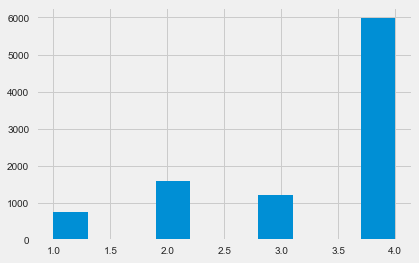

In [460]:
data['Target'].hist()

In [461]:
#there are many that are part of group 4, lets even out the sample. we'll drop 3/4 of group 4. 

In [462]:
data_undersampled=data.drop(data.query('Target == 4').sample(frac=.75).index)


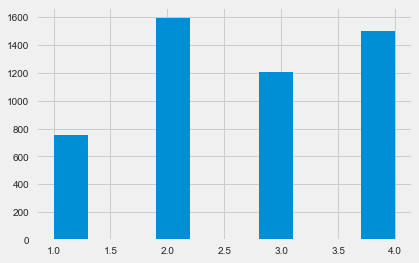

In [463]:
data_undersampled['Target'].hist()

In [464]:
X=data_undersampled.drop(['Id', 'idhogar', 'Target', 'edjefe', 'edjefa'], axis=1)
y=data_undersampled['Target']

In [465]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [466]:
X_train.shape

(23132, 140)

In [467]:
y_train.shape

(23132,)

In [468]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [469]:
clf = RandomForestClassifier()
params={'n_estimators': list(range(40,61, 1))}
gs = GridSearchCV(clf, params, cv=5)

In [470]:
gs.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

# This is where I could not find more progress after trying to clean the data from ways I understood on my own. From here I will use 1 kernel to clean the data, then I will use methods I understand to interpet the data and create a model. 

here is the link to the kernel I followed for cleaning. I will use those instructions for the next portion of the project. https://www.kaggle.com/katacs/data-cleaning-and-random-forest/notebook

In [471]:
data = pd.read_csv('/Users/tclawson/Desktop/HW4/train.csv')
test = pd.read_csv('/Users/tclawson/Desktop/HW4/test.csv')


In [472]:
data.columns[data.dtypes==object]

Index(['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa'], dtype='object')

In [473]:
data['dependency'].unique()

array(['no', '8', 'yes', '3', '.5', '.25', '2', '.66666669', '.33333334',
       '1.5', '.40000001', '.75', '1.25', '.2', '2.5', '1.2', '4',
       '1.3333334', '2.25', '.22222222', '5', '.83333331', '.80000001',
       '6', '3.5', '1.6666666', '.2857143', '1.75', '.71428573',
       '.16666667', '.60000002'], dtype=object)

In [474]:
data[(data['dependency']=='no') & (data['SQBdependency']!=0)]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target


In [475]:
data[(data['dependency']=='yes') & (data['SQBdependency']!=1)]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target


In [476]:
data[(data['dependency']=='3') & (data['SQBdependency']!=9)]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target


In [477]:
data['dependency']=np.sqrt(data['SQBdependency'])

In [478]:
data['edjefe'].unique()

array(['10', '12', 'no', '11', '9', '15', '4', '6', '8', '17', '7', '16',
       '14', '5', '21', '2', '19', 'yes', '3', '18', '13', '20'],
      dtype=object)

In [479]:
data['edjefa'].unique()

array(['no', '11', '4', '10', '9', '15', '7', '14', '13', '8', '17', '6',
       '5', '3', '16', '19', 'yes', '21', '12', '2', '20', '18'],
      dtype=object)

In [480]:
data['SQBedjefe'].unique()

array([100, 144,   0, 121,  81, 225,  16,  36,  64, 289,  49, 256, 196,
        25, 441,   4, 361,   1,   9, 324, 169, 400])

In [481]:
data[['edjefe', 'edjefa', 'SQBedjefe']][:20]

,edjefe,edjefa,SQBedjefe
0,10,no,100
1,12,no,144
2,no,11,0
3,11,no,121
4,11,no,121
5,11,no,121
6,11,no,121
7,9,no,81
8,9,no,81
9,9,no,81


In [482]:
data[['edjefe', 'edjefa', 'SQBedjefe']][data['edjefe']=='yes']

,edjefe,edjefa,SQBedjefe
601,yes,no,1
602,yes,no,1
2392,yes,no,1
2393,yes,no,1
2394,yes,no,1
2422,yes,no,1
2423,yes,no,1
2424,yes,no,1
2829,yes,no,1
2830,yes,no,1


In [483]:
data[(data['edjefe']=='yes') & (data['edjefa']!='no')]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target


In [484]:
data[(data['edjefa']=='yes') & (data['parentesco1']==1)][['edjefe', 'edjefa', 'parentesco1', 'escolari']]

,edjefe,edjefa,parentesco1,escolari
432,no,yes,1,1
568,no,yes,1,1
595,no,yes,1,1
976,no,yes,1,1
1574,no,yes,1,1
2464,no,yes,1,1
2614,no,yes,1,1
3469,no,yes,1,1
3855,no,yes,1,1
3952,no,yes,1,1


In [485]:
data[data['edjefe']=='yes'][['edjefe', 'edjefa','age', 'escolari', 'parentesco1','male', 'female', 'idhogar']]

,edjefe,edjefa,age,escolari,parentesco1,male,female,idhogar
601,yes,no,81,1,1,1,0,3641ce2d1
602,yes,no,73,3,0,0,1,3641ce2d1
2392,yes,no,42,6,0,0,1,a7abf59cc
2393,yes,no,12,5,0,0,1,a7abf59cc
2394,yes,no,46,1,1,1,0,a7abf59cc
2422,yes,no,41,6,0,1,0,698318dd7
2423,yes,no,74,1,0,0,1,698318dd7
2424,yes,no,78,1,1,1,0,698318dd7
2829,yes,no,72,4,0,0,1,4559a5af0
2830,yes,no,76,1,1,1,0,4559a5af0


In [486]:
data[(data['edjefe']=='no') & (data['edjefa']=='no')][['edjefe', 'edjefa', 'age', 'escolari', 'female', 'male', 'Id', 'parentesco1', 'idhogar']]

,edjefe,edjefa,age,escolari,female,male,Id,parentesco1,idhogar
86,no,no,89,0,1,0,ID_48c10ba80,1,2b1a06ddc
87,no,no,55,13,0,1,ID_1a283d51b,0,2b1a06ddc
121,no,no,21,14,1,0,ID_fdf18bbee,0,d9e9b591a
122,no,no,47,8,0,1,ID_cba836ed8,0,d9e9b591a
123,no,no,49,9,1,0,ID_6031cb88d,0,d9e9b591a
124,no,no,68,0,1,0,ID_0bc817cb2,1,d9e9b591a
125,no,no,21,14,1,0,ID_1cfb76926,0,d9e9b591a
166,no,no,6,0,1,0,ID_f435c5e46,0,71bec40bc
167,no,no,9,1,0,1,ID_a51262dae,0,71bec40bc
168,no,no,26,5,1,0,ID_7e6d23b28,0,71bec40bc


In [487]:
data[(data['edjefe']=='yes') & data['parentesco1']==1][['escolari']]

,escolari
601,1
2394,1
2424,1
2830,1
3017,1
3744,1
4491,1
4905,1
4980,1
5154,1


From Kernel

"Basically:

'edjefe' and 'edjefa' are both 'no' when the head of the household had 0 years of school
there's 'edjefe'= 'yes' and 'edjefa'='no' in some cases, all these cases the head of the household had 1 year of school
there's 'edjefe'= 'no' and 'edjefa'='yes' in some cases, all these cases the head of the household had 1 year of school
most of the time either 'edjefe' or 'edjefa' is a number while the other is a 'no'
Let's merge the jefe and jefa education into one, undependent of gender"

In [488]:
conditions = [
    (data['edjefe']=='no') & (data['edjefa']=='no'), #both no
    (data['edjefe']=='yes') & (data['edjefa']=='no'), # yes and no
    (data['edjefe']=='no') & (data['edjefa']=='yes'), #no and yes 
    (data['edjefe']!='no') & (data['edjefe']!='yes') & (data['edjefa']=='no'), # number and no
    (data['edjefe']=='no') & (data['edjefa']!='no') # no and number
]
choices = [0, 1, 1, data['edjefe'], data['edjefa']]
data['edjefx']=np.select(conditions, choices)
data['edjefx']=data['edjefx'].astype(int)
data[['edjefe', 'edjefa', 'edjefx']][:15]

,edjefe,edjefa,edjefx
0,10,no,10
1,12,no,12
2,no,11,11
3,11,no,11
4,11,no,11
5,11,no,11
6,11,no,11
7,9,no,9
8,9,no,9
9,9,no,9


In [489]:
data.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target,edjefx
count,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,1629.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.00000,9557.000000,9557.000000,9557.0,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.00000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000,9557.000000
mean,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,1.559171,1.945066,0.399184,1.661714,2.060898,0.785079,3.220885,4.005964,3.999058,4.094590,7.200272,0.459791,3.999058,0.594015,0.077744,0.188030,0.008580,0.115622,0.013079,0.001465,0.001465,0.692791,0.222873,0.000942,0.001046,0.016428,0.065920,0.970074,0.017683,0.003139,0.002197,0.677409,0.964738,0.031705,0.003558,0.885110,0.000314,0.002197,0.110809,0.003872,0.213979,0.764257,0.015381,0.002511,0.001883,0.489589,0.458407,0.050120,0.882704,0.03003,0.084545,0.001465,0.0,0.001256,0.102438,0.327404,0.570158,0.128388,0.288061,0.583551,0.101078,0.252799,0.646123,0.057549,0.483415,0.516585,0.137805,0.123260,0.268390,0.031914,0.062781,0.033169,0.342681,0.311081,0.184054,0.381814,0.012138,0.009522,0.051167,0.010045,0.002407,0.013289,0.003139,0.012661,0.008685,1.406613,2.592445,0.284085,3.999058,1.149550,9.231523,0.134666,0.170556,0.207701,0.185414,0.112692,0.017893,0.015

In [490]:
data.columns[data.isna().sum()!=0]

Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned'], dtype='object')

In [491]:
data[data['meaneduc'].isnull()]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target,edjefx
1291,ID_bd8e11b0f,NaN,0,7,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,10,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1b31fd159,1,0,0,1,8.0,no,10,NaN,0,0,0,1,0,0,0,0,0,5,0.2,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,0,18,100,324,1,0,1,0.04,64.0,NaN,324,4,10
1840,ID_46ff87316,110000.0,0,1,0,1,1,0,NaN,0,1,1,0,1,1,0,2,2,2,2,6,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,a874b7ce7,2,0,0,2,8.0,4,no,NaN,0,0,1,0,0,0,0,0,0,1,2.0,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,36,324,4,16,4,4.00,64.0,NaN,324,4,4
1841,ID_69f50bf3e,110000.0,0,1,0,1,1,0,NaN,0,1,1,0,1,1,0,2,2,2,2,4,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,a874b7ce7,2,0,0,2,8.0,4,no,NaN,0,1,0,0,0,0,0,0,0,1,2.0,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,16,324,4,16,4,4.00,64.0,NaN,324,4,4
2049,ID_db3168f9f,180000.0,0,3,0,1,1,0,NaN,0,2,2,0,0,0,0,2,2,2,2,12,NaN,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,faaebf71a,2,0,0,2,8.0,12,no,NaN,0,0,0,0,0,0,1,0,0,2,1.0,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,19,144,361,4,144,4,1.00,64.0,NaN,361,4,12
2050,ID_2a7615902,180000.0,0,3,0,1,1,0,NaN,0,2,2,0,0,0,0,2,2,2,2,12,NaN,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,faaebf71a,2,0,0,2,8.0,12,no,NaN,0,0,0,0,0,0,1,0,0,2,1.0,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,19,144,361,4,144,4,1.00,64.0,NaN,361,4,12


In [492]:
data[data['meaneduc'].isnull()][['Id','idhogar','edjefe','edjefa', 'hogar_adul', 'hogar_mayor', 'hogar_nin', 'age', 'escolari']]

,Id,idhogar,edjefe,edjefa,hogar_adul,hogar_mayor,hogar_nin,age,escolari
1291,ID_bd8e11b0f,1b31fd159,no,10,0,0,1,18,10
1840,ID_46ff87316,a874b7ce7,4,no,0,0,2,18,6
1841,ID_69f50bf3e,a874b7ce7,4,no,0,0,2,18,4
2049,ID_db3168f9f,faaebf71a,12,no,0,0,2,19,12
2050,ID_2a7615902,faaebf71a,12,no,0,0,2,19,12


In [493]:
print(len(data[data['idhogar']==data.iloc[1291]['idhogar']]))
print(len(data[data['idhogar']==data.iloc[1840]['idhogar']]))
print(len(data[data['idhogar']==data.iloc[2049]['idhogar']]))

1
2
2


In [494]:
meaneduc_nan=data[data['meaneduc'].isnull()][['Id','idhogar','escolari']]

In [495]:
me=meaneduc_nan.groupby('idhogar')['escolari'].mean().reset_index()

In [496]:
me

,idhogar,escolari
0,1b31fd159,10
1,a874b7ce7,5
2,faaebf71a,12


In [497]:
for row in meaneduc_nan.iterrows():
    idx=row[0]
    idhogar=row[1]['idhogar']
    m=me[me['idhogar']==idhogar]['escolari'].tolist()[0]
    data.at[idx, 'meaneduc']=m
    data.at[idx, 'SQBmeaned']=m*m

In [498]:
data['v2a1'].isnull().sum()

6860

In [499]:
norent=data[data['v2a1'].isnull()]
print("Owns his house:", norent[norent['tipovivi1']==1]['Id'].count())
print("Owns his house paying installments", norent[norent['tipovivi2']==1]['Id'].count())
print("Rented ", norent[norent['tipovivi3']==1]['Id'].count())
print("Precarious ", norent[norent['tipovivi4']==1]['Id'].count())
print("Other ", norent[norent['tipovivi5']==1]['Id'].count())
print("Total ", 6860)

Owns his house: 5911
Owns his house paying installments 0
Rented  0
Precarious  163
Other  786
Total  6860


In [500]:
#lets assume they dont pay rent
data['v2a1']=data['v2a1'].fillna(0)

In [501]:
data['v18q1'].isna().sum()

7342

In [502]:
tabletnan=data[data['v18q1'].isnull()]
tabletnan[tabletnan['v18q']==0]['Id'].count()

7342

In [503]:
data['v18q1'].unique()

array([nan,  1.,  2.,  3.,  4.,  5.,  6.])

In [504]:
data['v18q1']=data['v18q1'].fillna(0)

In [505]:
data['rez_esc'].isnull().sum()

7928

In [506]:
data['rez_esc'].describe()

count    1629.000000
mean        0.459791
std         0.946550
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         5.000000
Name: rez_esc, dtype: float64

In [507]:
data['rez_esc'].unique()

array([nan,  1.,  0.,  3.,  2.,  4.,  5.])

In [508]:
data[data['rez_esc']>1][['age', 'escolari', 'rez_esc']][:20]

,age,escolari,rez_esc
185,13,3,3.0
190,16,7,2.0
240,16,6,3.0
242,11,2,2.0
312,15,6,2.0
317,17,6,4.0
319,17,7,3.0
320,15,6,2.0
333,16,7,2.0
510,16,7,2.0


In [509]:
rez_esc_nan=data[data['rez_esc'].isnull()]
rez_esc_nan[(rez_esc_nan['age']<18) & rez_esc_nan['escolari']>0][['age', 'escolari']]

,age,escolari


In [510]:
data['rez_esc']=data['rez_esc'].fillna(0)

In [511]:
d={}
weird=[]
for row in data.iterrows():
    idhogar=row[1]['idhogar']
    target=row[1]['Target']
    if idhogar in d:
        if d[idhogar]!=target:
            weird.append(idhogar)
    else:
        d[idhogar]=target

In [353]:
len(set(weird))

85

In [354]:
data[data['idhogar']==weird[2]][['idhogar','parentesco1', 'Target']]

,idhogar,parentesco1,Target
285,6833ac5dc,0,2
286,6833ac5dc,0,2
287,6833ac5dc,0,2
288,6833ac5dc,1,2
289,6833ac5dc,0,2
290,6833ac5dc,0,1


In [355]:
for i in set(weird):
    hhold=data[data['idhogar']==i][['idhogar', 'parentesco1', 'Target']]
    target=hhold[hhold['parentesco1']==1]['Target'].tolist()[0]
    for row in hhold.iterrows():
        idx=row[0]
        if row[1]['parentesco1']!=1:
            data.at[idx, 'Target']=target

In [356]:
data[data['idhogar']==weird[1]][['idhogar','parentesco1', 'Target']]

,idhogar,parentesco1,Target
282,4b6077882,1,1
283,4b6077882,0,1
284,4b6077882,0,1


In [357]:
def data_cleaning(data):
    data['dependency']=np.sqrt(data['SQBdependency'])
    data['rez_esc']=data['rez_esc'].fillna(0)
    data['v18q1']=data['v18q1'].fillna(0)
    data['v2a1']=data['v2a1'].fillna(0)
    
    conditions = [
    (data['edjefe']=='no') & (data['edjefa']=='no'), #both no
    (data['edjefe']=='yes') & (data['edjefa']=='no'), # yes and no
    (data['edjefe']=='no') & (data['edjefa']=='yes'), #no and yes 
    (data['edjefe']!='no') & (data['edjefe']!='yes') & (data['edjefa']=='no'), # number and no
    (data['edjefe']=='no') & (data['edjefa']!='no') # no and number
    ]
    choices = [0, 1, 1, data['edjefe'], data['edjefa']]
    data['edjefx']=np.select(conditions, choices)
    data['edjefx']=data['edjefx'].astype(int)
    data.drop(['edjefe', 'edjefa'], axis=1, inplace=True)
    
    meaneduc_nan=data[data['meaneduc'].isnull()][['Id','idhogar','escolari']]
    me=meaneduc_nan.groupby('idhogar')['escolari'].mean().reset_index()
    for row in meaneduc_nan.iterrows():
        idx=row[0]
        idhogar=row[1]['idhogar']
        m=me[me['idhogar']==idhogar]['escolari'].tolist()[0]
        data.at[idx, 'meaneduc']=m
        data.at[idx, 'SQBmeaned']=m*m
        
    return data

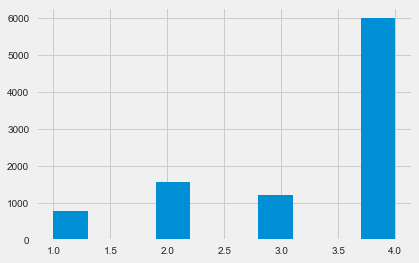

In [358]:
data['Target'].hist()

In [359]:
#some kernels use a resampled set of data, they use the folowwing code
#data_undersampled=data.drop(data.query('Target == 4').sample(frac=.75).index)

#X=data_undersampled.drop(['Id', 'idhogar', 'Target', 'edjefe', 'edjefa'], axis=1)
#y=data_undersampled['Target']

#they create the x and y from resampled data that uses 1/4 of the category 4 data. 

In [360]:
X=data.drop(['Id', 'idhogar', 'Target', 'edjefe', 'edjefa'], axis=1)
y=data['Target']

In [393]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Logistic regression

Here i will use a simple logistic regression to create some predictions, this code and methodology largely comes from class lecture 5 https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_5_Logistic_Regression_and_Evaluation.ipynb

In [362]:
#Here we can import the logistic regression and see how many we predicited accuratley compared to the y. 

from sklearn import linear_model
logreg = linear_model.LogisticRegression()
logreg.fit(X, y)

sum(y == logreg.predict(X))

6349

ok, 6349 correct out of how many?
lets get a look at the y cloumn to see how many exist.

In [363]:
y

0       4
1       4
2       4
3       4
4       4
5       4
6       4
7       4
8       4
9       4
10      4
11      4
12      4
13      4
14      4
15      4
16      4
17      4
18      4
19      4
20      4
21      4
22      4
23      4
24      4
25      4
26      4
27      4
28      4
29      4
       ..
9527    4
9528    4
9529    4
9530    4
9531    4
9532    4
9533    4
9534    3
9535    1
9536    1
9537    1
9538    1
9539    1
9540    2
9541    2
9542    2
9543    2
9544    2
9545    4
9546    4
9547    4
9548    4
9549    4
9550    2
9551    2
9552    2
9553    2
9554    2
9555    2
9556    2
Name: Target, Length: 9557, dtype: int64

OK!!! 6349 out of 9557. about 66% accuracy. this is not bad considering it is the most simple classifying model. But as we learned, this is a pretty poor test of a model.

Les try to take a look at F1 from this logistic prediction.

In [381]:
from sklearn.metrics import f1_score

In [365]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          1       0.09      0.07      0.08       151
          2       0.17      0.14      0.15       321
          3       0.12      0.10      0.11       248
          4       0.62      0.69      0.65      1192

avg / total       0.44      0.47      0.45      1912



# Random Forest

In [375]:
clf = RandomForestClassifier()
params={'n_estimators': list(range(40,61, 1))}
gs = GridSearchCV(clf, params, cv=5)

TO build and understand the best random forset model lets see what hyper parameters are helpful in creating the best model.

In [376]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [377]:
preds=gs.predict(X_test)

After understanding what hyper parameters we are using to make the best model, lets test for f1.

In [378]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          1       0.98      0.85      0.91       151
          2       0.98      0.83      0.90       321
          3       1.00      0.79      0.89       248
          4       0.91      1.00      0.95      1192

avg / total       0.94      0.93      0.93      1912



Our model has improved drastically!! This is a great win for us and for random forest.

In [382]:
print(gs.best_params_)
print(gs.best_score_)
print(gs.best_estimator_)

{'n_estimators': 55}
0.9156311314584696
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


The information above helps us see what was the best model and gives insight into what is working. 55 n_estimators, we are using a bootstrap and other insights are found above.

In [384]:
#this code shows what is working and how the model came to decide that 55 n_estmators would be ideal.

cvres = gs.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), params)

0.9525017831101379 {'n_estimators': 40}
0.953256783741325 {'n_estimators': 41}
0.9542168296628248 {'n_estimators': 42}
0.9539426294187547 {'n_estimators': 43}
0.9541482869891982 {'n_estimators': 44}
0.9542853674132931 {'n_estimators': 45}
0.9549019858002623 {'n_estimators': 46}
0.9548334923105354 {'n_estimators': 47}
0.9548334923105354 {'n_estimators': 48}
0.9525704442587662 {'n_estimators': 49}
0.9534625892455924 {'n_estimators': 50}
0.953805499736537 {'n_estimators': 51}
0.9525704442587662 {'n_estimators': 52}
0.9555182062689572 {'n_estimators': 53}
0.9549704743774206 {'n_estimators': 54}
0.9568861643155206 {'n_estimators': 55}
0.954559469204789 {'n_estimators': 56}
0.9560656243638588 {'n_estimators': 57}
0.954559469204789 {'n_estimators': 58}
0.9544224281489964 {'n_estimators': 59}
0.9542853674132931 {'n_estimators': 60}


# K nearest neighbors

In [387]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error

reg = KNeighborsRegressor()
gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
y_pred_test = gridsearch.predict(X_test)
print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Best Params: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Train MSE: 0.0	Test MSE: 0.7867931379698967


In [401]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred_train))

             precision    recall  f1-score   support

          1       0.07      0.07      0.07       612
          2       0.16      0.16      0.16      1249
          3       0.14      0.14      0.14       992
          4       0.63      0.63      0.63      4792

avg / total       0.44      0.45      0.44      7645



This model also falls short. I think under the right hyper parameters and with a better understanding of k nearest neighbors I could make this a much better model. 

# Conclusion

This is a great example of the power of random forest. With relatively little effort we created a fantastic model with random forest. 